In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
import os, sys
import numpy as np
import pandas as pd

import config_readwrite as crw

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")
import plot_params as pp

pp.fonts()

('sans-serif', 'Arial', 18)

# config

In [2]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

In [3]:
CL = "HEPG2"
DATAHEPG2 = config["mpra"][f'{CL}.clean.transformed'] 

CL = "BJ"
DATABJ = config["mpra"][f'{CL}.clean.transformed'] 
ANALYSIS = 'US_UP0.9_v_US_UP0.1_shuf_CTRL_UP0.9'

FASTA = config["mpra"]["fasta"]

MEME = config["meme"]["src"]
FIMO = config["fimo"]["src"]
RESULTS = config["path"]["results"]
BED = config["mpra"]["tile.bed"]

RE_MEME = os.path.join(RESULTS, "meme")
RE_MEME_CL = os.path.join(RE_MEME, CL, ANALYSIS)

# make the results
for dirname in [RE_MEME, RE_MEME_CL]:
    if os.path.exists(dirname) is False:
        os.mkdir(dirname)

# append meme path
sys.path.append(MEME)

# change directory 
os.chdir(RE_MEME_CL)

In [4]:
# write

section = "meme"

config[section][f'results'] = RE_MEME
config[section][CL] = RE_MEME_CL

crw.write(config, cfn)

# load data

In [5]:
def openAndFilter(file_name):
    df = pd.read_csv(file_name, sep='\t')  # (58333, 38)
    print("before filtering", file_name,  df.shape)
    df = df.loc[~df["label"].str.contains("Synthetic")].reset_index(
        drop=True)  # (26803, 38)
    print("filter out synthetics", df.shape)
    df = df.loc[~df["label"].str.contains("Pos")].reset_index(
        drop=True)  # (26659, 38)
    print("filter out positive controls", df.shape, '\n\n')

    return df

In [6]:
#hepg2 = openAndFilter(DATAHEPG2)
bj = openAndFilter(DATABJ)

before filtering /wynton/group/ahituv/fongsl/projects/US/data/full_bj_MPRA.clean.transformed.csv (58333, 38)
filter out synthetics (26803, 38)
filter out positive controls (26659, 38) 




In [7]:
bj.shape

(26659, 38)

In [8]:
enh = pd.read_csv(BED, sep='\t')
enh.head()

,name,enh.id,enh.name
0,hob_k27ac_down_chr1:826978-827247,chr1:826978-827704,enh.0
1,hob_k27ac_down_chr1:827110-827379,chr1:826978-827704,enh.0
2,hob_k27ac_down_chr1:827377-827646,chr1:826978-827704,enh.0
3,hob_k27ac_down_chr1:827435-827704,chr1:826978-827704,enh.0
4,hob_k27ac_down_chr1:827891-828160,chr1:827891-828160,enh.1


In [9]:
bj = pd.merge(bj, enh, how="left")

# add direction 

In [10]:
def labelDirection(df):

    """label sequences with different directions of change between US and Control
    note

    neg.US_UP == US MPRA activity is negative, but less negative than CTRL MPRA activity, which is also negative
    pos.US_UP  == US MPRA activity is positive and more positive than CTRL MPRA activity, which is also positive. 
    US_UP == US activity is positive and higher than CTRL MPRA activity, which is negative. 
    """
    df["direction"] = None

    # Pos values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Pos.US_UP"

    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Pos.CTRL_UP"

    # Negtaive values only
    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Neg.CTRL_DOWN"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Neg.US_DOWN"

    # crossing zero values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "US_UP"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "CTRL_UP"

    print(df.loc[df["direction"] != None, ["l2.ratio.mean.ctrl",
          "l2.ratio.mean.us", 'delta.mean', "direction"]].sample(n=20))
    return df


In [11]:
bj = labelDirection(bj)

       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean      direction
17085           -0.184853         -0.249937   -0.065084    Neg.US_DOWN
3639             0.457633          0.505077    0.047444      Pos.US_UP
20523            0.429226          0.486880    0.057653      Pos.US_UP
13567            0.462182          0.436069   -0.026112    Pos.CTRL_UP
9962             0.089291          0.125868    0.036577      Pos.US_UP
9207            -0.645421         -0.685857   -0.040436    Neg.US_DOWN
25878            0.124889          0.111203   -0.013687    Pos.CTRL_UP
17878            0.035063         -0.016496   -0.051559        CTRL_UP
3005            -1.973819         -1.863673    0.110146  Neg.CTRL_DOWN
3036             0.087146          0.136230    0.049084      Pos.US_UP
8674            -0.235694         -0.336868   -0.101174    Neg.US_DOWN
15476            0.167287          0.108120   -0.059167    Pos.CTRL_UP
1651             0.178534          0.245787    0.067253      Pos.US_UP
9491  

In [12]:
set(bj["label"])

{'Differential_ATAC',
 'Differential_H3K27ac',
 'NegCtl_Ilias_MPRA',
 'NegCtl_Vikram_MPRA',
 'Non-differential',
 'Promoter_DEG',
 'Shuffle'}

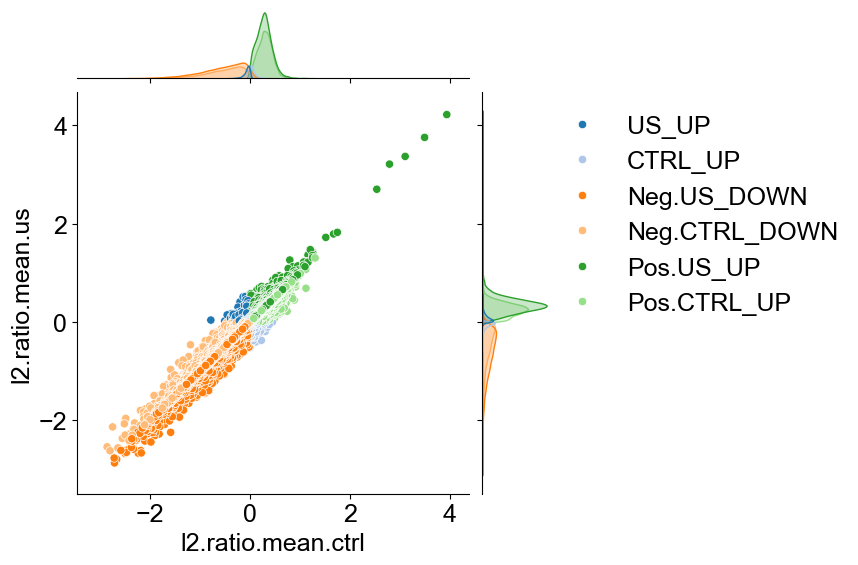

In [13]:
# 
#fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=bj, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

# US up - BJ

## functions

In [44]:
def getDfDirectionSub(df, direction):
    """subset dataframe by directino of effect"""

    cols = ["name", "label", "l2.ratio.mean.ctrl",
        'l2.ratio.mean.us', "delta.mean", "direction"]

    df = df.loc[df["direction"] == direction, cols].sort_values(
        by='l2.ratio.mean.us', ascending=False).copy()

    return df


def getQuantileDelta(df, top_quantile, base_df, shuf_bkgd=False):
    """subset dataframe by delta.mean top/bottom quantiles, return dataframes, list of names"""

    # top quantile of delta.means
    pos = df.loc[df["delta.mean"] >=
                     df["delta.mean"].quantile(top_quantile)].copy()

    # pos list of names
    pos_names = list(pos["name"])

    # bottom quantile of delta.means.
    neg = df.loc[df["delta.mean"] <=
                     df["delta.mean"].quantile(1-top_quantile)].copy()
    if shuf_bkgd is True:
        shuf = base_df.loc[base_df['label'] ==
            "Shuffle"].copy().drop_duplicates()
        neg = pd.concat([neg, shuf])

    # neg list of names
    neg_names = list(neg["name"])

    return pos, pos_names, neg, neg_names


def makeQuantileFasta(pos_names, neg_names, direction, re, top_quantile, exp_name, fa):
    """write fastas for each quantile based on list of sequence names"""

    bottom_quantile = round(1-top_quantile, 1)

    # files to write
    FA_POS = os.path.join(re, f"{exp_name}.{direction}.pos.{top_quantile}.fa")
    FA_NEG = os.path.join(
        re, f"{exp_name}.{direction}.neg.{bottom_quantile}.fa")

    # write positive, negative names and sequences
    for names, fa_write in [(pos_names, FA_POS), (neg_names, FA_NEG)]:

        # filter and write fasta function
        filterWriteFasta(fa_write, fa, names)

    return FA_POS, FA_NEG


def filterWriteFasta(fa_write_file, source_fa, seq_id_list):
    """provide file to write, source fasta, and sequence list"""
    fa_writer = open(fa_write_file, "w")  # open fa file to write

    with open(source_fa, "r") as reader:  # open the full fa file
        for value in sfp(reader):
            seq_id, seq = value  # get sequence id, sequence
            if seq_id in seq_id_list:  # filter for sequences in pos/neg name list
                # write those sequences to fa
                fa_writer.write(f'>{seq_id}\n{seq}\n')
    fa_writer.close()

def getEnhSet(df, name_set):
    """return list of enhancer names and linked tiles to prevent data leakage"""
    enh_names = df.loc[df["name"].isin(name_set), "enh.name"].unique()
    linkedtiles = df.loc[df["enh.name"].isin(enh_names), "name"].unique()
    
    return enh_names, linkedtiles

def runFimo(fimo, meme_txt, fa, direction, quantile):

    OUTDIR = f"./fimo/{direction}.{quantile}"
    if os.path.exists('./fimo') is False:
        os.mkdir("./fimo/")

    cmd = " ".join([fimo,
                    "--oc",
                    OUTDIR,
                    meme_txt,
                    fa,

                    ])
    if os.path.exists(OUTDIR) is False:
        os.system(cmd)

    return OUTDIR

## Experiment 1: Motif discovery on top 10% of US-increasing sequences v. bottom 10% of US-increasing sequences. 
     - Hyp - top 10% reflects true signal, bottom 10% is noise, the shuffles are noise, the repressed sequences are a different set of elements. Motifs enriched in the top 10% of US-sensitive elements not found in bottom 10% are likely important for US-dependent TF binding. 
    - Data Universe: BJ MPRA, all of the sequences where the contrl MPRA value is negative and US MPRA value is positive

In [15]:
EXP_NAME ="exp1"
DIRECTION = "US_UP"
NEG_DIRECTION="CTRL_UP"
df = bj
TOP_QUANTILE = 0.9
BOTTOM_QUANTILE = round((1-TOP_QUANTILE),1)

### US-increasing sequences only

In [16]:
### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)
neg_df_dir = getDfDirectionSub(df, NEG_DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, True)
print(len(neg_names))
# top US_down elements to add to the background
neg_pos, neg_pos_names, neg_neg, neg_neg_names = getQuantileDelta(neg_df_dir, TOP_QUANTILE, df, True)

# add top_US_down names to the negative list. 
neg_names.extend(neg_neg_names)
neg = pd.concat([neg, neg_neg])
print(len(neg_names))
# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names, neg_names, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)

# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

exp1up, exp1down = pos_names, neg_names

364
723


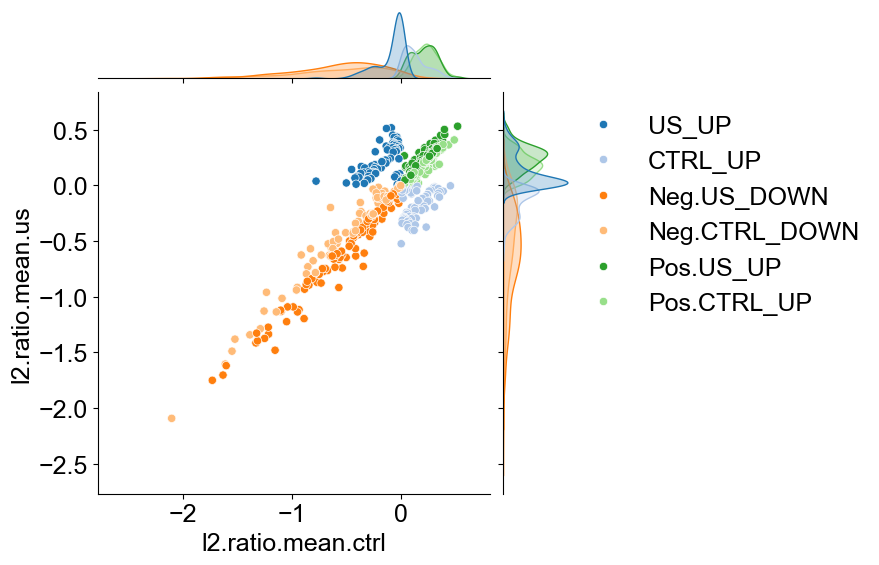

In [17]:
plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

### sanity check - delta scores are larger than expected from shuffle.  

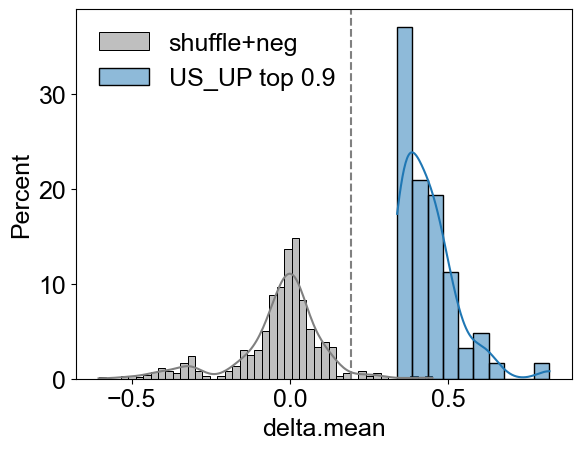

In [18]:
shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
sns.histplot(x="delta.mean", data=neg, label="shuffle+neg", kde=True,
             stat="percent", color="grey", common_norm=False)

# draw upper 97.5% line
ax.axvline(neg["delta.mean"].quantile(0.975), ls = "--", c="grey")

sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
plt.legend(frameon=False, loc="upper left")



#### delta.mean stats - shuf, us_up

In [19]:
neg["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

(0.1915729764900124,
 count    62.000000
 mean      0.434824
 std       0.089431
 min       0.338595
 25%       0.371489
 50%       0.424342
 75%       0.476606
 max       0.819849
 Name: delta.mean, dtype: float64)

### MEME motif discovery

#### MEME params

In [20]:
# MEME PARAMS - https://meme-suite.org/meme/doc/meme.html?man_type=web
OUTPUT_DIR = RE_MEME_CL 
OBJ_FUN = "de" # differential enrichment, uses multiple hypergeometric test (mhg) as stat to measure enrichment
TEST = "mhg"
MIN_WIDTH = 10
MAX_WIDTH = 15

N_SITES = 10  # find motifs with N sites
N_MOTIFS = 3 # n motifes to find

#### MEME cmd, run

In [21]:
args = [FA_POS,
        "-oc", OUTPUT_DIR,
        '-objfun', OBJ_FUN,
        "-neg", FA_NEG,
        "-dna",  # use DNA alphabet
        "-minw", MIN_WIDTH,
        '-maxw', MAX_WIDTH,
        "-allw",  # test starts for all widths
        "-nsites", N_SITES,  # number of sites for each motif
        "-nmotifs", N_MOTIFS
        ]

# add meme args together
cmd = [MEME] + args

# transform into a str
cmd = " ".join([str(i) for i in cmd])

# run command
os.system(cmd)

# write the output meme file
MEME_TXT = os.path.join(RE_MEME_CL, f"{CL}.{DIRECTION}.{TOP_QUANTILE}.meme.txt")

# rename the membe file
os.system(f"mv meme.txt {CL}.{DIRECTION}.{TOP_QUANTILE}.meme.txt")

config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.meme'] = MEME_TXT

crw.write(config, cfn)

The output directory '/wynton/group/ahituv/fongsl/projects/US/results/meme/BJ/US_UP0.9_v_US_UP0.1_shuf_CTRL_UP0.9' already exists.
Its contents will be overwritten.
BACKGROUND: using background model of order 0
PRIMARY (de): n 62 p0 31 p1 15 p2 16
CONTROL (de): n 416 c0 62 c1 177 c2 177
SEQUENCE GROUP USAGE-- Starts/EM: p0 vs c0; Trim: p1 vs c1; pvalue: p2 vs c1,c2; nsites: p0,p1,p2 vs c0,c1,c2
SEEDS: maxwords 16740 highwater mark: seq 31 pos 260
all widths from min to max

seqs=    62, min_w= 270, max_w=  270, total_size=    16740

motif=1
SEED DEPTHS: estimated from data
SEED WIDTHS: 10 11 12 13 14 15
em: w=  15, psites=  10, iter=  30 
motif=2
SEED DEPTHS: estimated from data
SEED WIDTHS: 10 11 12 13 14 15
em: w=  15, psites=  10, iter=  40 
motif=3
SEED DEPTHS: estimated from data
SEED WIDTHS: 10 11 12 13 14 15
em: w=  15, psites=  10, iter=  40 


### MEME output
     /wynton/group/ahituv/fongsl/projects/US/results/meme/BJ

In [26]:
neg.shape

(723, 40)

In [25]:
%%bash
ls -l /wynton/group/ahituv/fongsl/projects/US/results/meme/BJ/US_UP0.9_v_US_UP0.1_shuf_CTRL_UP0.9

total 150
-rw-r--r--. 1 fongsl ahituv  28930 Apr 10 13:39 BJ.US_UP.0.9.meme.txt
-rw-r--r--. 1 fongsl ahituv 147538 Apr 10 13:39 exp1.US_UP.neg.0.1.fa
-rw-r--r--. 1 fongsl ahituv  19429 Apr 10 13:38 exp1.US_UP.pos.0.9.fa
-rw-r--r--. 1 fongsl ahituv  13581 Apr 10 13:39 logo1.eps
-rw-r--r--. 1 fongsl ahituv  15961 Apr 10 13:39 logo1.png
-rw-r--r--. 1 fongsl ahituv  13559 Apr 10 13:39 logo2.eps
-rw-r--r--. 1 fongsl ahituv  14139 Apr 10 13:39 logo2.png
-rw-r--r--. 1 fongsl ahituv  13743 Apr 10 13:39 logo3.eps
-rw-r--r--. 1 fongsl ahituv  17620 Apr 10 13:39 logo3.png
-rw-r--r--. 1 fongsl ahituv  13581 Apr 10 13:39 logo_rc1.eps
-rw-r--r--. 1 fongsl ahituv  16739 Apr 10 13:39 logo_rc1.png
-rw-r--r--. 1 fongsl ahituv  13559 Apr 10 13:39 logo_rc2.eps
-rw-r--r--. 1 fongsl ahituv  17217 Apr 10 13:39 logo_rc2.png
-rw-r--r--. 1 fongsl ahituv  13743 Apr 10 13:39 logo_rc3.eps
-rw-r--r--. 1 fongsl ahituv  18624 Apr 10 13:39 logo_rc3.png
-rw-r--r--. 1 fongsl ahituv 351257 Apr 10 13:39 meme.html
-rw-r--r

### Fimo on full dataset

        # without repressed (CTRL_UP, top 90%) in bkgd
         top 90% US_UP bkgd discovered motifs with bkgd - bottom 10% US_UP, shuffle bkgd
        CAGRCTCTCS
        CCTGKRTGWGW
        GAGRAGVMAGCMK
        
        
        # WITH repressed in bkgd
        top 90% US_UP bkgd discovered motifs with bkgd - bottom 10% US_UP, shuffle bkgd, and CTRL_UP top 90% (repressed) 
        TCTTCCTSCT
        SCWGCAGHKCCM
        CYTGGGAGGAG
        

In [23]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

Using motif +CWGGCCCTGG of width 10.
Using motif -CWGGCCCTGG of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.8192
#   Estimated pi_0=0.8192
Using motif +CTCTTCCTCC of width 10.
Using motif -CTCTTCCTCC of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.8978
#   Estimated pi_0=0.903046
Using motif +WSYCCAGCCYCT of width 12.
Using motif -WSYCCAGCCYCT of width 12.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.927848
#   Estimated pi_0=0.933494
Unable to create output directory './fimo/US_UP.0.9': No such file or directory.
FATAL: Couldn't create output directory ./fimo/US_UP.0.9.

Using motif +CWGGCCCTGG of width 10.
Using motif -CWGGCCCTGG of width 10.
Co

In [24]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)


bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'shuf+bottom0.1+top0.9repressed'
bdf["-log10q"]  = -1*np.log10(bdf["q-value"])
print(bdf.shape)

FileNotFoundError: [Errno 2] No such file or directory: './fimo/US_UP.0.9/fimo.tsv'

In [27]:
# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])

plot = plot.loc[~plot["motif_alt_id"].isna()]

NameError: name 'tdf' is not defined

ValueError: Could not interpret value `motif_alt_id` for `x`. An entry with this name does not appear in `data`.

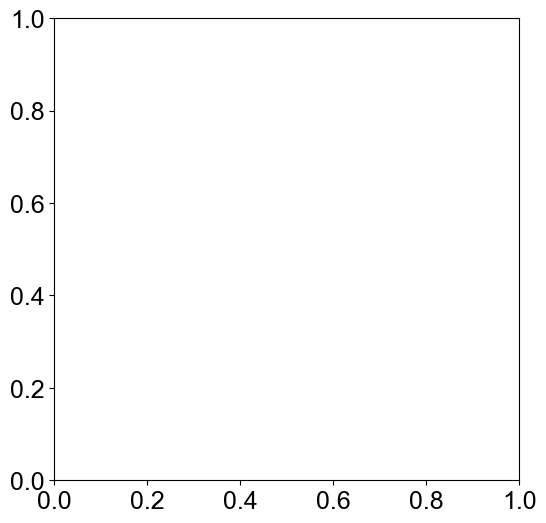

In [28]:
fig, ax= plt.subplots( figsize = (6,6))
sns.violinplot(x="motif_alt_id", y='-log10q', data= plot, hue="quantile", 
               order = ["MEME-1", "MEME-2", "MEME-3"])
#ax.set(ylim=(-0.10,2.75))
ax.legend(frameon=False, loc='upper right')

In [ ]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

# Validation

## Experiment 2: are motifs discovered in US_UP also discovered in POS.US_UP?
    - hypothesis: top motifs in us_up are also driving increased activity in pos.US_up. 
    - approach: use FIMO to discover US_UP motifs in other data. 
    - data universe: sequences with positive baseline activity that increase activity w/ US

In [29]:
EXP_NAME ="exp2"
DIRECTION = "Pos.US_UP"

### pos.us_up sequences only

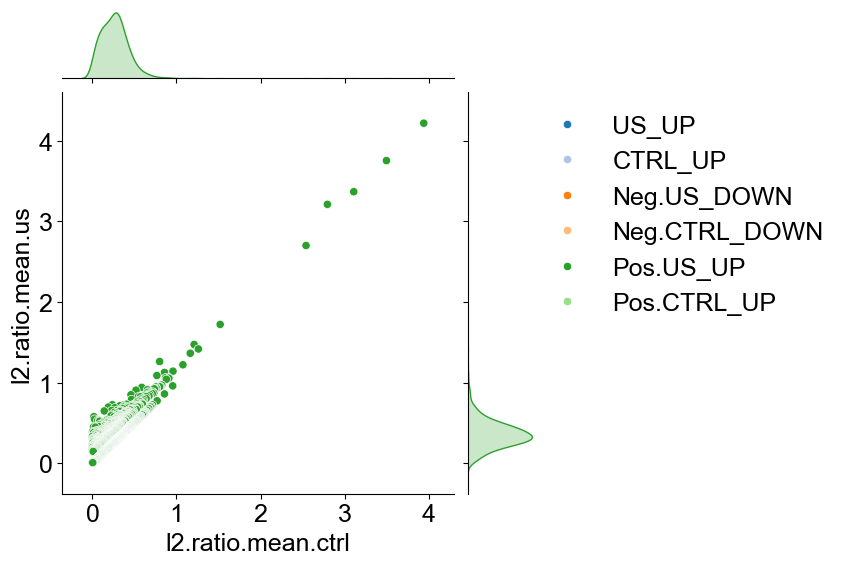

In [30]:
### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means, no shuffle data leakage
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

### clean up data leakage
- tiled enhancers which may have overlapping information

In [31]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

In [32]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)

# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

### sanity check

In [33]:
pos.shape, neg.shape

((938, 6), (938, 6))

In [34]:
neg["delta.mean"].describe()

count    9.380000e+02
mean     3.866601e-03
std      2.236341e-03
min      4.420462e-07
25%      1.985475e-03
50%      3.822364e-03
75%      5.754043e-03
max      7.845641e-03
Name: delta.mean, dtype: float64

(0.22299430179288693,
 count    938.000000
 mean       0.199157
 std        0.065295
 min        0.134542
 25%        0.150366
 50%        0.178526
 75%        0.226405
 max        0.558532
 Name: delta.mean, dtype: float64)

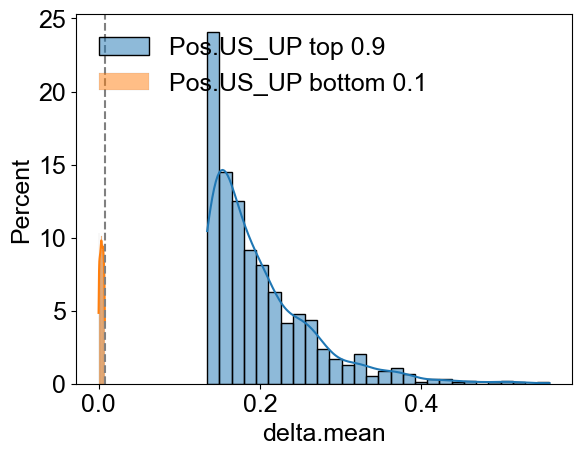

In [35]:
shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
#sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
 #            stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
# draw upper 97.5% line
ax.axvline(neg["delta.mean"].quantile(0.975), ls = "--", c="grey")

plt.legend(frameon=False, loc="upper left")



shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

### Fimo

In [45]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

Using motif +CWGGCCCTGG of width 10.
Using motif -CWGGCCCTGG of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.889
#   Estimated pi_0=0.891533
Using motif +CTCTTCCTCC of width 10.
Using motif -CTCTTCCTCC of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.92349
#   Estimated pi_0=0.926923
Using motif +WSYCCAGCCYCT of width 12.
Using motif -WSYCCAGCCYCT of width 12.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.924427
#   Estimated pi_0=0.929317
Using motif +CWGGCCCTGG of width 10.
Using motif -CWGGCCCTGG of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal

### FET enrichment

(1316, 12)
(423, 12)


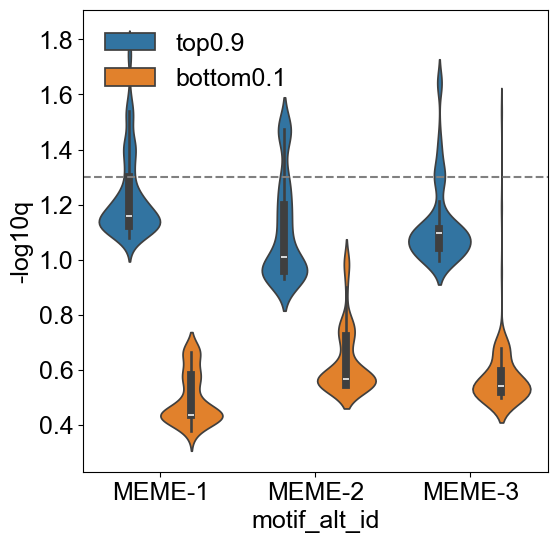

In [50]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"]  = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])
plot = plot.loc[~plot["motif_alt_id"].isna()]
fig, ax= plt.subplots( figsize = (6,6))
sns.violinplot(x="motif_alt_id", y='-log10q', data= plot, hue="quantile", 
               order = ["MEME-1", "MEME-2", "MEME-3"])
ax.axhline(np.log10(0.05)*-1, ls="--", color="grey")
ax.legend(frameon=False, loc='upper left')

In [47]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

MEME-1 MannwhitneyuResult(statistic=54890.0, pvalue=5.892528992812789e-61)
MEME-2 MannwhitneyuResult(statistic=60244.0, pvalue=1.7492547573840372e-69)
MEME-3 MannwhitneyuResult(statistic=63023.5, pvalue=5.005145467085248e-70)


In [48]:
plot.groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       bottom0.1       110            110    110   110     110    110   
             top0.9          499            499    499   499     499    499   
MEME-2       bottom0.1       164            164    164   164     164    164   
             top0.9          377            377    377   377     377    377   
MEME-3       bottom0.1       146            146    146   146     146    146   
             top0.9          437            437    437   437     437    437   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       bottom0.1      110      110               110      110  
             top0.9         499      499               499      499  
MEME-2       bottom0.1      164      164               164      164  
             top0.9         377      377               377      377  
MEME-3       bottom0.1      146      146               146      146  
             top0.9         437      437               437      437

In [49]:
# how many significant motifs in each group?
plot.loc[plot["q-value"]<=0.05].groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       top0.9          114            114    114   114     114    114   
MEME-2       top0.9           58             58     58    58      58     58   
MEME-3       bottom0.1         1              1      1     1       1      1   
             top0.9           56             56     56    56      56     56   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       top0.9         114      114               114      114  
MEME-2       top0.9          58       58                58       58  
MEME-3       bottom0.1        1        1                 1        1  
             top0.9          56       56                56       56

## Experiment 3 - motif enrichment in repressed sequences? 

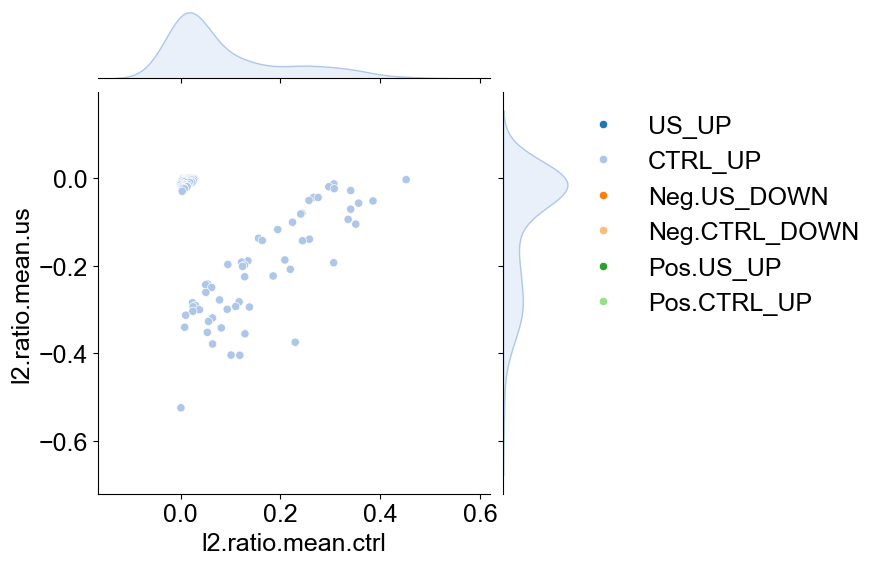

In [51]:
EXP_NAME ="exp3"
DIRECTION = "CTRL_UP"

### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

In [52]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

(       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean
 count           57.000000         57.000000   57.000000
 mean             0.010691         -0.009347   -0.020037
 std              0.007635          0.007759    0.008507
 min              0.000229         -0.030260   -0.033020
 25%              0.004751         -0.014953   -0.028137
 50%              0.008242         -0.006720   -0.020227
 75%              0.014982         -0.003216   -0.012091
 max              0.027397         -0.000022   -0.005002,
        l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean
 count           57.000000         57.000000   57.000000
 mean             0.165902         -0.209212   -0.375113
 std              0.115981          0.123086    0.071058
 min              0.000303         -0.524368   -0.604310
 25%              0.063525         -0.299698   -0.414182
 50%              0.128747         -0.208249   -0.353442
 75%              0.257206         -0.100876   -0.320026
 max              0.452162    

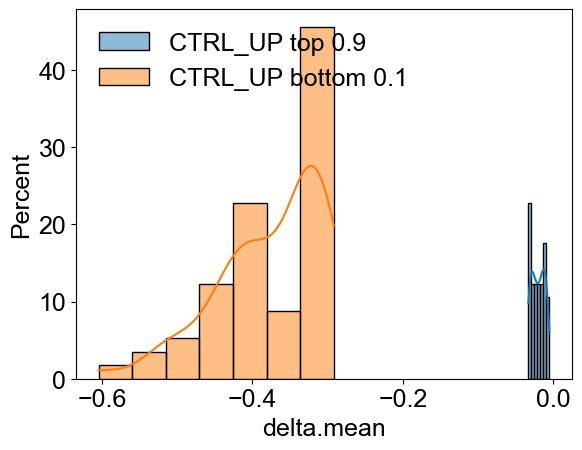

In [53]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)


# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
#sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
 #            stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False, #color="orange", 
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False, #color="blue",
             stat="percent")
plt.legend(frameon=False, loc="upper left")

shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

pos.describe(), neg.describe()

In [54]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

Using motif +CWGGCCCTGG of width 10.
Using motif -CWGGCCCTGG of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.991746
#   Estimated pi_0=0.993061
Using motif +CTCTTCCTCC of width 10.
Using motif -CTCTTCCTCC of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.974152
#   Estimated pi_0=0.97871
Using motif +WSYCCAGCCYCT of width 12.
Using motif -WSYCCAGCCYCT of width 12.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.985172
#   Estimated pi_0=0.989845
Using motif +CWGGCCCTGG of width 10.
Using motif -CWGGCCCTGG of width 10.
Computing q-values.
Using motif +CTCTTCCTCC of width 10.
Using motif -CTCTTCCTCC of width 10.
Computing q-values.
Using motif +WSYCCAGCCY

In [55]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"] = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"] = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])
plot = plot.loc[~plot["motif_alt_id"].isna()]

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x="motif_alt_id", y='-log10q', data=plot, hue="quantile",
               #hue_order=["bottom0.1", "top0.1"],
               order=["MEME-1", "MEME-2", "MEME-3"])
#ax.set(ylim=(-0.20,2.75))
ax.legend(frameon=False, loc='upper left')

(36, 12)


KeyError: 'q-value'

In [ ]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

In [ ]:
plot.groupby(["motif_alt_id", "quantile"]).count()

In [ ]:
# how many significant motifs in each group?
plot.loc[plot["q-value"]<=0.05].groupby(["motif_alt_id", "quantile"]).count()

## Experiment 4 - motifs in repressed sequences (CTRL positive, US reduced positive)

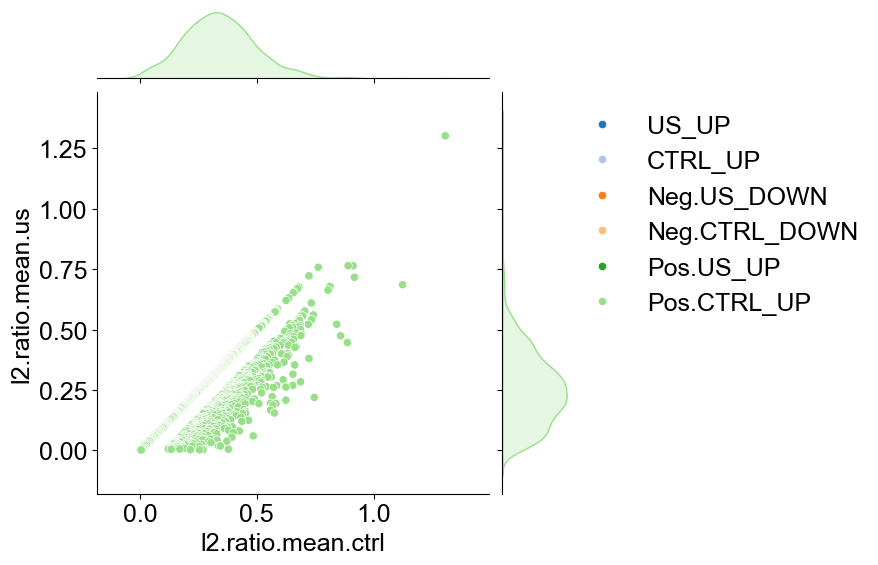

In [56]:
EXP_NAME ="exp4"
DIRECTION = "Pos.CTRL_UP"

### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

In [57]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

(       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean
 count          665.000000        665.000000  665.000000
 mean             0.295332          0.292508   -0.002824
 std              0.145520          0.145534    0.001560
 min              0.001684          0.000847   -0.005523
 25%              0.197816          0.194600   -0.004215
 50%              0.294463          0.290687   -0.002754
 75%              0.390845          0.386992   -0.001542
 max              1.305856          1.302752   -0.000012,
        l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean
 count          665.000000        665.000000  665.000000
 mean             0.387397          0.211237   -0.176160
 std              0.148404          0.138767    0.060408
 min              0.121941          0.001687   -0.526881
 25%              0.279159          0.102199   -0.201403
 50%              0.375915          0.195145   -0.157504
 75%              0.468022          0.293020   -0.134289
 max              1.123083    

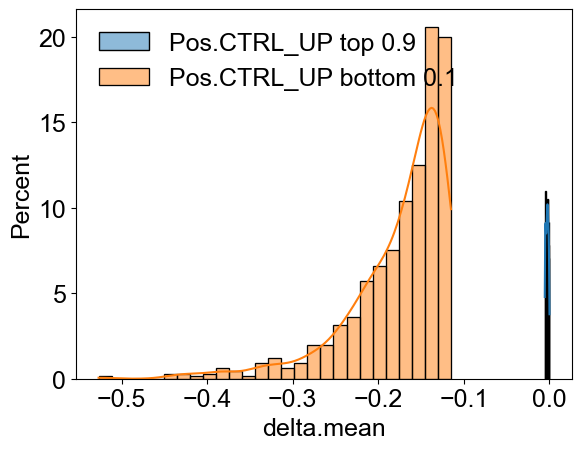

In [58]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)


# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
#sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
 #            stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False, #color="orange", 
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False, #color="blue",
             stat="percent")
plt.legend(frameon=False, loc="upper left")

shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

pos.describe(), neg.describe()

In [59]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

Using motif +CWGGCCCTGG of width 10.
Using motif -CWGGCCCTGG of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.997026
#   Estimated pi_0=0.998693
Using motif +CTCTTCCTCC of width 10.
Using motif -CTCTTCCTCC of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.986522
#   Estimated pi_0=0.993909
Using motif +WSYCCAGCCYCT of width 12.
Using motif -WSYCCAGCCYCT of width 12.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.992526
#   Estimated pi_0=0.995228
Using motif +CWGGCCCTGG of width 10.
Using motif -CWGGCCCTGG of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Min

In [60]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf = tdf.loc[~tdf["motif_alt_id"].isna()]
tdf["quantile"] = 'top0.9'
tdf["-log10q"] = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

(365, 12)


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,quantile,-log10q
0,WSYCCAGCCYCT,MEME-3,hob_atac_up_chr16:16074502-16074771,48.0,59.0,+,19.3578,6.230000e-08,0.0212,ACCCCAGCCCCT,top0.9,1.673664
1,WSYCCAGCCYCT,MEME-3,hob_k27ac_up_chr4:168096404-168096673,144.0,155.0,-,18.6330,2.000000e-07,0.0341,TGCCCAGCCCCT,top0.9,1.467246
2,WSYCCAGCCYCT,MEME-3,k562_k27ac_up_chr1:100510976-100511245,243.0,254.0,-,18.4312,3.270000e-07,0.0372,TCCCCAGCCCCC,top0.9,1.429457
3,WSYCCAGCCYCT,MEME-3,hob_atac_up_chr15:31639036-31639305,64.0,75.0,+,17.8991,4.960000e-07,0.0401,ACTCCAGCCTCT,top0.9,1.396856
4,CWGGCCCTGG,MEME-1,hob_k27ac_up_chr5:38782493-38782762,162.0,171.0,+,18.9908,5.030000e-07,0.0867,CTGGCCCTGG,top0.9,1.061981


In [61]:
bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf = bdf.loc[~bdf["motif_alt_id"].isna()]
bdf["-log10q"] = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

(866, 12)


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,quantile,-log10q
0,WSYCCAGCCYCT,MEME-3,hob_k27ac_down_chr3:112086596-112086865,139.0,150.0,+,19.3578,6.230000e-08,0.00963,TCCCCAGCCCCT,bottom0.1,2.016374
1,WSYCCAGCCYCT,MEME-3,bj_k27ac_up_chr2:112149965-112150234,259.0,270.0,-,19.3578,6.230000e-08,0.00963,ACCCCAGCCCCT,bottom0.1,2.016374
2,WSYCCAGCCYCT,MEME-3,bj_atac_up_chr22:22022468-22022737,207.0,218.0,-,18.6330,2.000000e-07,0.02020,TGCCCAGCCCCT,bottom0.1,1.694649
3,WSYCCAGCCYCT,MEME-3,hepg2_atac_up_chr4:8999420-8999689,75.0,86.0,+,18.4954,2.760000e-07,0.02020,TCCCCAGCCTCT,bottom0.1,1.694649
4,WSYCCAGCCYCT,MEME-3,hob_atac_up_chr11:64545657-64545926,14.0,25.0,-,18.4312,3.270000e-07,0.02020,TCCCCAGCCCCC,bottom0.1,1.694649


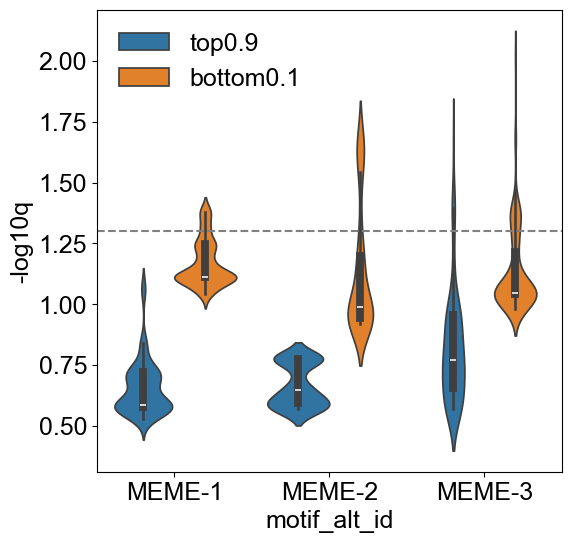

In [64]:
# concatenate the top and bottom values
if bdf.shape[0]>3:
    plot = pd.concat([tdf, bdf])
else:
    plot=tdf
plot = plot.loc[~plot["motif_alt_id"].isna()]

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x="motif_alt_id", y='-log10q', data=plot, hue="quantile",
               #hue_order=["bottom0.1", "top0.1"],
               order=["MEME-1", "MEME-2", "MEME-3"])
ax.axhline(np.log10(0.05)*-1, ls="--", color="grey")
ax.legend(frameon=False, loc='upper left')

In [65]:
tdf.loc[~tdf["motif_alt_id"].isna()]

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,quantile,-log10q
0,WSYCCAGCCYCT,MEME-3,hob_atac_up_chr16:16074502-16074771,48.0,59.0,+,19.35780,6.230000e-08,0.0212,ACCCCAGCCCCT,top0.9,1.673664
1,WSYCCAGCCYCT,MEME-3,hob_k27ac_up_chr4:168096404-168096673,144.0,155.0,-,18.63300,2.000000e-07,0.0341,TGCCCAGCCCCT,top0.9,1.467246
2,WSYCCAGCCYCT,MEME-3,k562_k27ac_up_chr1:100510976-100511245,243.0,254.0,-,18.43120,3.270000e-07,0.0372,TCCCCAGCCCCC,top0.9,1.429457
3,WSYCCAGCCYCT,MEME-3,hob_atac_up_chr15:31639036-31639305,64.0,75.0,+,17.89910,4.960000e-07,0.0401,ACTCCAGCCTCT,top0.9,1.396856
4,CWGGCCCTGG,MEME-1,hob_k27ac_up_chr5:38782493-38782762,162.0,171.0,+,18.99080,5.030000e-07,0.0867,CTGGCCCTGG,top0.9,1.061981
...,...,...,...,...,...,...,...,...,...,...,...,...
360,WSYCCAGCCYCT,MEME-3,K562_up-DEG-prom_ENSG00000005882_chr17:5009371...,145.0,156.0,+,7.85321,9.960000e-05,0.2690,ATCCCAGCTACT,top0.9,0.570248
361,WSYCCAGCCYCT,MEME-3,hepg2_atac_down_chr11:65926749-65927018,188.0,199.0,-,7.85321,9.960000e-05,0.2690,ATCCCAGCTACT,top0.9,0.570248
362,WSYCCAGCCYCT,MEME-3,bj_k27ac_up_chr3:124007926-124008195,203.0,214.0,+,7.85321,9.960000e-05,0.2690,ATCCCAGCTACT,top0.9,0.570248
363,WSYCCAGCCYCT,MEME-3,hob_k27ac_up_chr10:68043446-68043715,251.0,262.0,+,7.85321,9.960000e-05,0.2690,ATCCCAGCTACT,top0.9,0.570248


In [66]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

MEME-1 MannwhitneyuResult(statistic=120.0, pvalue=7.643784975227437e-57)
MEME-2 MannwhitneyuResult(statistic=0.0, pvalue=5.423943210588491e-57)
MEME-3 MannwhitneyuResult(statistic=3447.0, pvalue=3.946337702314047e-40)


In [67]:
plot.groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       bottom0.1       318            318    318   318     318    318   
             top0.9          113            113    113   113     113    113   
MEME-2       bottom0.1       254            254    254   254     254    254   
             top0.9          126            126    126   126     126    126   
MEME-3       bottom0.1       294            294    294   294     294    294   
             top0.9          126            126    126   126     126    126   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       bottom0.1      318      318               318      318  
             top0.9         113      113               113      113  
MEME-2       bottom0.1      254      254               254      254  
             top0.9         126      126               126      126  
MEME-3       bottom0.1      294      294               294      294  
             top0.9         126      126               126      126

In [68]:
# how many significant motifs in each group?
plot.loc[plot["q-value"]<=0.05].groupby(["motif_alt_id", "quantile"]).count()

motif_id  sequence_name  start  stop  strand  score  \
motif_alt_id quantile                                                         
MEME-1       bottom0.1        45             45     45    45      45     45   
MEME-2       bottom0.1        53             53     53    53      53     53   
MEME-3       bottom0.1        57             57     57    57      57     57   
             top0.9            9              9      9     9       9      9   

                        p-value  q-value  matched_sequence  -log10q  
motif_alt_id quantile                                                
MEME-1       bottom0.1       45       45                45       45  
MEME-2       bottom0.1       53       53                53       53  
MEME-3       bottom0.1       57       57                57       57  
             top0.9           9        9                 9        9

# luciferase tested elements. 

## load experiment data 

In [69]:
LUC="/wynton/group/ahituv/fongsl/projects/US/data/validation_luc/Candidate_ID_table_luc.txt"

luc = pd.read_csv(LUC, sep='\t')

luc_names = list(luc["insert"])  # list of tiles tested in luciferase


# successful results where luciferase direction matches 
success = ["BJ_D2", "BJ_D3", "BJ_D4", "BJ_D7", "BJ_D8", 'BJ_D9', "BJ_U9"]

# annotate dataframe with sucesses
luc["success"] = False
luc.loc[luc["Sample name"].isin(success), "success"] = True
#luc.loc[~luc["Sample name"].str.contains(CL), "success"] = "other-cl"

luc.rename(columns = {"insert":"sequence_name", 
                     "Sample name": 'label_id'}, inplace=True)
luc

,Sample ID,label_id,sequence_name,type.x,label,pval,logFC,control_ratio,ultrasound_ratio,dir,sequence,success
0,1,BJ_D1,hob_atac_up_chr22:41305657-41305926,"top_5_significant, top_5_largest_logFC, pval_p...",Differential_ATAC,0.001828,-0.387330,1.496837,1.144397,DOWN,AGTAGGTTTCTAACTGCAGAAAGCAGAATGGCAGTAGAAGGAGGAC...,False
1,2,BJ_D2,hepg2_atac_down_chr10:109895366-109895635,"top_5_significant, top_5_largest_logFC, pval_p...",Differential_ATAC,0.000797,-0.373681,1.300464,1.003713,DOWN,GGAAGATCCGCAGGGTTTACCTAGACTTCTCCATCAGCAAAGGCAA...,True
2,3,BJ_D3,hob_atac_up_chr3:127734774-127735043,logFC<-0.25_peakp<0.05_responseTrue,Differential_ATAC,0.009797,-0.255964,1.233940,1.033336,DOWN,ATCTCTCCTCAGGTGACTAAGCCAGCCAGTCATGGCAGGCACACGG...,True
3,4,BJ_D4,SYNTHETIC:_Added_TGTAACAA_AGGTGTCA_AAGACCCCTC_...,"top_5_significant, top_5_largest_logFC",Synthetic,0.000569,-0.221765,1.269305,1.088449,DOWN,GACAGGTGTCATTTGTCTGGCAACGTGTCTGGAATAACTTCCAAGA...,True
4,5,BJ_D5,hob_k27ac_up_chr12:32115256-32115525,"top_3_largest_logFC_bc100, top_5_barcodes",Differential_H3K27ac,0.002897,-0.155360,1.268955,1.139405,DOWN,TAAATTAATAGTTTTCCCTTCTTCTCCCACAGTTCTGTCTCTGTTG...,False
5,6,BJ_D6,SYNTHETIC:_Added_AGGGGAGGTATT_AGCAACCA_CCCCCGC...,top_5_barcodes,Synthetic,0.003760,-0.124638,1.305544,1.197490,DOWN,GACGCTTACTGTGTACCCCCGCCCCTGTCTGGAATAACTTCCAAGA...,False
6,7,BJ_D7,SYNTHETIC:_Added_GCCCGGGGG_GGCCATTAAC_TATGACTC...,top_5_significant,Synthetic,0.000707,-0.169443,1.424512,1.266656,DOWN,GACGCTTACTGTGTAGAGGCCAACCCCCCCCCAATAACTTCCAAGA...,True
7,8,BJ_D8,SYNTHETIC:_Added_GTGGTGTGTG_CGCCACGGCGGGGGTGGA...,top_5_largest_logFC,Synthetic,0.004943,-0.197340,1.473556,1.285172,DOWN,GACGCTTACTGTGTAGAGGCGTGGTGTGTGGGAATAGCAGCTGAGA...,True
8,9,BJ_D9,SYNTHETIC:_The_motif_GGGGCGGGG_was_added_in_Po...,top_5_largest_logFC,Synthetic,0.003534,-0.294115,1.358003,1.107549,DOWN,GACGCTTACTGTGTAGAGGCCAACGTGTCTGGAATAACTTCCAAGA...,True
9,10,BJ_U1,hob_k27ac_up_chr2:145036567-145036836,"top_5_significant, top_3_significant_bc100, to...",Differential_H3K27ac,0.000716,0.107081,1.211559,1.304906,UP,CTAGTTCATAGTTGGTCCAGTTTTCCCATTTTCTAAACCACAACTA...,False


## make fasta

In [70]:
LUC_FA = LUC.strip(".txt") + '.fa'
filterWriteFasta(LUC_FA, FASTA, luc_names)

## fimo

In [71]:
OUTDIR_LUC =  runFimo(FIMO, MEME_TXT, LUC_FA, "Luc", "all")

Using motif +CWGGCCCTGG of width 10.
Using motif -CWGGCCCTGG of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.901379
#   Estimated pi_0=0.909007
Using motif +CTCTTCCTCC of width 10.
Using motif -CTCTTCCTCC of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.925844
#   Estimated pi_0=0.925844
Using motif +WSYCCAGCCYCT of width 12.
Using motif -WSYCCAGCCYCT of width 12.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.940621
#   Estimated pi_0=0.943952


In [72]:
pred = os.path.join(OUTDIR_LUC, "fimo.tsv")

tdf = pd.read_csv(pred, sep='\t')
tdf["quantile"] = 'LUC.matches'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf = tdf.loc[~tdf["motif_alt_id"].isna()]
tdf

(44, 12)


,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,quantile,-log10q
0,CWGGCCCTGG,MEME-1,hepg2_atac_up_chr16:85650086-85650355,199.0,208.0,-,18.99080,5.030000e-07,0.00322,CTGGCCCTGG,LUC.matches,2.492144
1,CWGGCCCTGG,MEME-1,hob_atac_up_chr22:30250826-30251095,217.0,226.0,+,18.99080,5.030000e-07,0.00322,CTGGCCCTGG,LUC.matches,2.492144
2,CTCTTCCTCC,MEME-2,hob_atac_up_chr2:127153718-127153987,145.0,154.0,+,17.76150,7.460000e-07,0.00974,CTCTTCCTCC,LUC.matches,2.011441
3,CWGGCCCTGG,MEME-1,bj_k27ac_up_chr4:53763341-53763610,110.0,119.0,+,18.41280,1.010000e-06,0.00430,CAGGCCCTGG,LUC.matches,2.366532
4,CWGGCCCTGG,MEME-1,k562_atac_up_chr7:1917897-1918166,189.0,198.0,-,15.84400,3.520000e-06,0.01130,CTGGCCGTGG,LUC.matches,1.946922
5,CTCTTCCTCC,MEME-2,hob_k27ac_down_chr16:2904526-2904795,125.0,134.0,+,14.89910,6.880000e-06,0.04490,CGCTTCCTCC,LUC.matches,1.347754
6,CTCTTCCTCC,MEME-2,hepg2_atac_down_chr10:109895366-109895635,258.0,267.0,+,14.56880,1.040000e-05,0.04510,CTCCTTCTCC,LUC.matches,1.345823
7,CWGGCCCTGG,MEME-1,hob_atac_up_chr22:41305657-41305926,209.0,218.0,-,12.87160,1.200000e-05,0.03080,CTGGGGCTGG,LUC.matches,1.511449
8,CWGGCCCTGG,MEME-1,hob_atac_up_chr18:11954494-11954763,188.0,197.0,-,12.69720,1.470000e-05,0.03150,CTGGGCGTGG,LUC.matches,1.501689
9,CWGGCCCTGG,MEME-1,hepg2_atac_up_chr16:85650086-85650355,56.0,65.0,+,12.11930,2.540000e-05,0.04650,CAGGGCGTGG,LUC.matches,1.332547


In [73]:
luc_fimo = pd.merge(luc[["label_id", "sequence_name", "success"]],
                    tdf, how="right").sort_values(by='success', ascending=False)
luc_fimo['label_id_success'] = luc_fimo["label_id"] + ".success." + luc_fimo['success'].map(str)

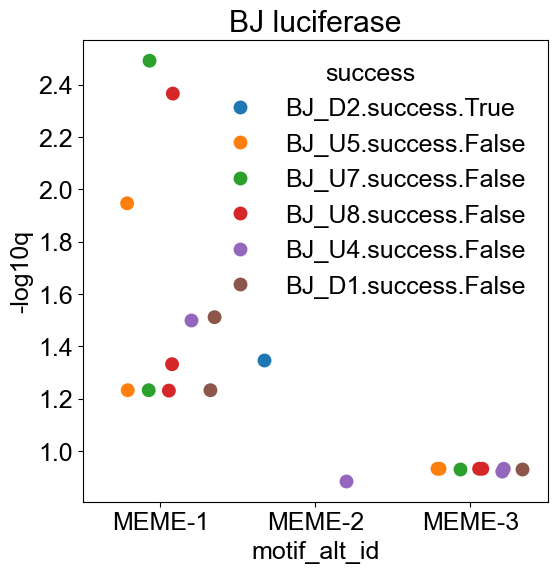

In [74]:
x="motif_alt_id"
y="-log10q"
hue="label_id_success"
order=["MEME-1", "MEME-2", "MEME-3"]
data=luc_fimo.loc[luc_fimo["label_id"].str.contains(CL)].sort_values(by='success', ascending=False)

fig, ax = plt.subplots(figsize=(6,6))
sns.stripplot(x=x,y=y, hue=hue, order=order, jitter=True,
              data=data, dodge = True, s=10)
ax.set(title=f"{CL} luciferase")
ax.legend(title="success", frameon=False, bbox_to_anchor=(1,1))

In [75]:
table = data.groupby(["motif_alt_id", "label_id", "success"])['-log10q'].max().reset_index(
).pivot(index="motif_alt_id", columns=[ "label_id",], values="-log10q")#.fillna(0)

<Axes: xlabel='label_id', ylabel='motif_alt_id'>

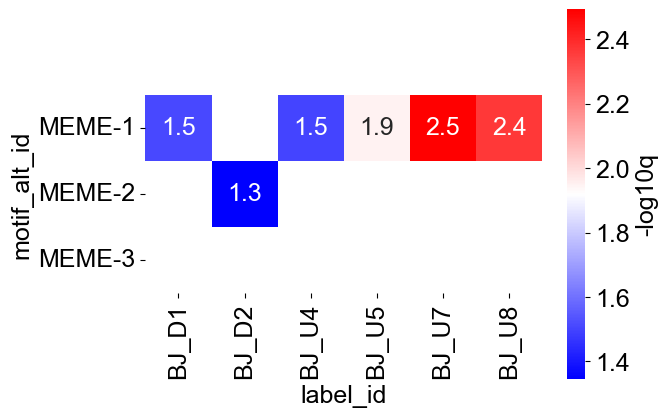

In [77]:
sns.heatmap(table, mask = table<np.log10(0.05)*-1, 
            square=True, cmap="bwr", 
            annot=True, 
            cbar_kws={"label":"-log10q"}
           )